#  <center> RFM Analysis on Superstore Data <center>
Data source:  [kaggle](https://www.kaggle.com/datasets/bravehart101/sample-supermarket-dataset?select=SampleSuperstore.csv)
***
RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.  

* Recency: When was the user’s most recent transaction?  

* Frequency:How often does the user transact?

* Monetary (M): What is the size of the user’s transaction?

 The best RFM score is the one with the highest values for each variable. If a store uses a 1 to 5 scale for recency, frequency, and monetary, with 5 being the highest, then the perfect RFM score is 555

In [320]:
# import relevant libraries
import pandas as pd
from sklearn.cluster import KMeans # to create clusters
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,7) # to set the default height and width of all plots in this notebook
plt.style.use('ggplot') # to use R's ggplot style for visuals
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl') # to silence warnings for the module 'openpyxl'

In [321]:
# 
df = pd.read_excel('Sample - Superstore.xlsx')
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [322]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9983.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55245.233297,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32038.715955,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,57103.000000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

In [324]:
df.isna().sum()

Row ID             0
Order ID           0
Order Date         0
Ship Date          0
Ship Mode          0
Customer ID        0
Customer Name      0
Segment            0
Country/Region     0
City               0
State              0
Postal Code       11
Region             0
Product ID         0
Category           0
Sub-Category       0
Product Name       0
Sales              0
Quantity           0
Discount           0
Profit             0
dtype: int64

In [325]:
# drop na in postal code
df = df[df['Postal Code'].notna()]

In [326]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [327]:
# drop irrelevant columns
df.drop('Row ID', axis = 1, inplace = True)

## Calculate Recency

In [328]:
# what is the most recent date in the entire data set
#we're going to use this to calculate recency for all customers

df['Order Date'].max()

Timestamp('2019-12-30 00:00:00')

In [329]:
# Group customer IDs by their most recent purchases
recency = df.groupby('Customer ID')['Order Date'].max()
recency.head(2)

Customer ID
AA-10315   2019-06-29
AA-10375   2019-12-11
Name: Order Date, dtype: datetime64[ns]

In [330]:
#calculate recency days by substracting each date from the max purchase date in the dataset
# Keep the negatives so that during clustering, lower numbers will have lower scores
recency = recency - df['Order Date'].max()
recency.head()

Customer ID
AA-10315   -184 days
AA-10375    -19 days
AA-10480   -259 days
AA-10645    -55 days
AB-10015   -415 days
Name: Order Date, dtype: timedelta64[ns]

AA-10315: -184 days from the most recent order date ( 2019-12-30)

In [331]:
#extract only number of days portion from recency values
recency = recency.dt.days

#see the results
recency.head()

Customer ID
AA-10315   -184
AA-10375    -19
AA-10480   -259
AA-10645    -55
AB-10015   -415
Name: Order Date, dtype: int64

In [332]:
#TODO: Drename series to recency so that we can use that name as a column name for the RFM DataFrame we will create
#your code here. name it 'Recency'
recency = recency.rename('Recency', inplace = True)
recency.head(2)

Customer ID
AA-10315   -184
AA-10375    -19
Name: Recency, dtype: int64

In [333]:
#create a new DataFrame called 'RFM' using the recency series as the data for this dataframe.
RFM = pd.DataFrame(recency)

#pop out CustomerID to become a column. 
RFM.reset_index(inplace = True)
RFM.head(2)

,Customer ID,Recency
0,AA-10315,-184
1,AA-10375,-19


In [334]:
RFM.describe()

,Recency
count,793.000000
mean,-147.292560
std,186.465917
min,-1164.000000
25%,-183.000000
50%,-76.000000
75%,-30.000000
max,0.000000


75% of clients ordered something 30 days before the most recent order date  
50% ordered something 76 days before the last day of business on record  
25% of the customers ordered something from the store 183 days before the last recorded order date  
As at december 30 2019, the last time one of the store's customers ordered something was 1,164 days ago

The boxplot below is a visual representation of these facts

<AxesSubplot:ylabel='Recency'>

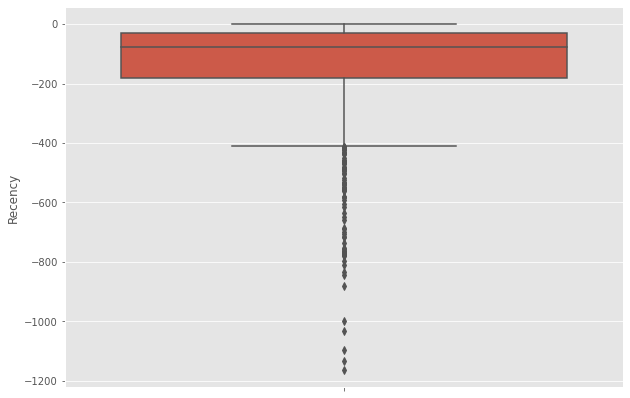

In [335]:
sns.boxplot(y = 'Recency', data = RFM)

### Calculate frequency

In [336]:
df.groupby('Customer ID')['Customer ID'].count()

Customer ID
AA-10315    11
AA-10375    15
AA-10480    12
AA-10645    18
AB-10015     6
            ..
XP-21865    28
YC-21895     8
YS-21880    12
ZC-21910    31
ZD-21925     9
Name: Customer ID, Length: 793, dtype: int64

Customer AA-10315 made  11 orders

In [337]:
# create series with variable name 'frequency' using the aggregated counts per customer ID above
frequency = df.groupby('Customer ID')['Customer ID'].count()

In [338]:
# Rename the series, not variable name to frequency with a capital F
frequency = frequency.rename('Frequency', inplace = True)

In [339]:
#Merge this frequency series into the RFM dataframe
#rename the series inline
RFM = RFM.merge(frequency,on='Customer ID')
RFM.head(2)

,Customer ID,Recency,Frequency
0,AA-10315,-184,11
1,AA-10375,-19,15


In [340]:
RFM.describe()

,Recency,Frequency
count,793.000000,793.000000
mean,-147.292560,12.588903
std,186.465917,6.242165
min,-1164.000000,1.000000
25%,-183.000000,8.000000
50%,-76.000000,12.000000
75%,-30.000000,16.000000
max,0.000000,37.000000


(0.0, 45.0)

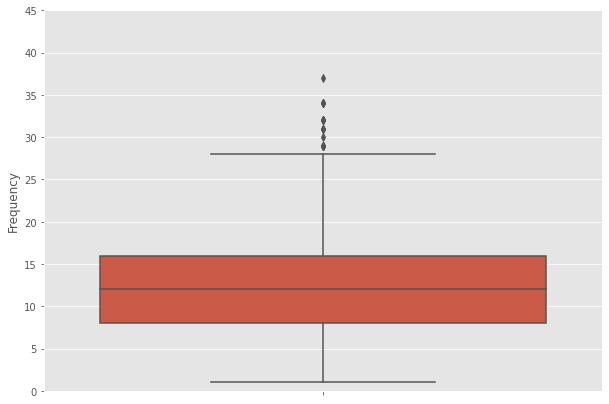

In [341]:
sns.boxplot( y = 'Frequency', data = RFM)
plt.ylim(0,45)

75% of the customers order something 16 times  
25% are repeat customers of 8 orders 
One customer has ordered 27 times

(0.0, 45.0)

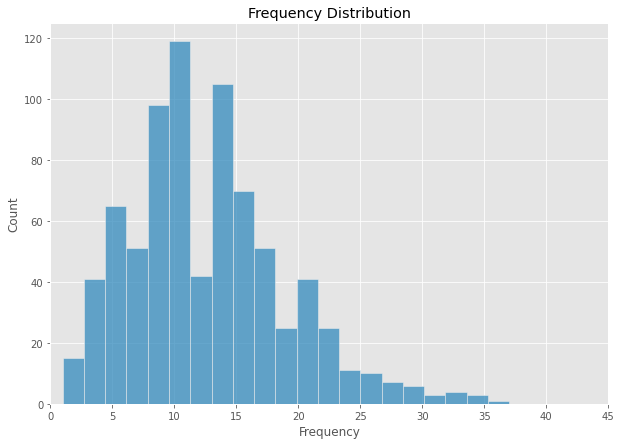

In [342]:
sns.histplot(data = RFM['Frequency'])
plt.title('Frequency Distribution')
plt.xlim(0,45)

In [343]:
df['year'] = df['Order Date'].dt.year

In [344]:
df.head(2)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,year
0,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,2018
1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,2018


## Calculate monetary value

In [345]:
# Sales = Sale made in USD
df.groupby('Customer ID').Sales.sum() 


Customer ID
AA-10315    5563.560
AA-10375    1056.390
AA-10480    1790.512
AA-10645    5086.935
AB-10015     886.156
              ...   
XP-21865    2374.658
YC-21895    5454.350
YS-21880    6720.444
ZC-21910    8025.707
ZD-21925    1493.944
Name: Sales, Length: 793, dtype: float64

In [346]:
# create series with variable name 'monetary' using the aggregated sum per customer ID above
monetary = df.groupby('Customer ID').Sales.sum()

# rename the series to 'Monetary' with a capital M. Note: you're not renaming the variable name but the series name 

monetary = monetary.rename('Monetary', inplace = True)

In [347]:
#Merge this monetary series into the RFM dataframe
RFM = RFM.merge(monetary, on = 'Customer ID')
RFM.head(2)

,Customer ID,Recency,Frequency,Monetary
0,AA-10315,-184,11,5563.56
1,AA-10375,-19,15,1056.39


Customer with ID AA-10315 has spent $5563.56 between 2016 and 2019

In [348]:
RFM.describe()

,Recency,Frequency,Monetary
count,793.000000,793.000000,793.000000
mean,-147.292560,12.588903,2885.588260
std,186.465917,6.242165,2627.150235
min,-1164.000000,1.000000,4.833000
25%,-183.000000,8.000000,1137.616000
50%,-76.000000,12.000000,2243.510000
75%,-30.000000,16.000000,3747.668000
max,0.000000,37.000000,25043.050000


(0.0, 10000.0)

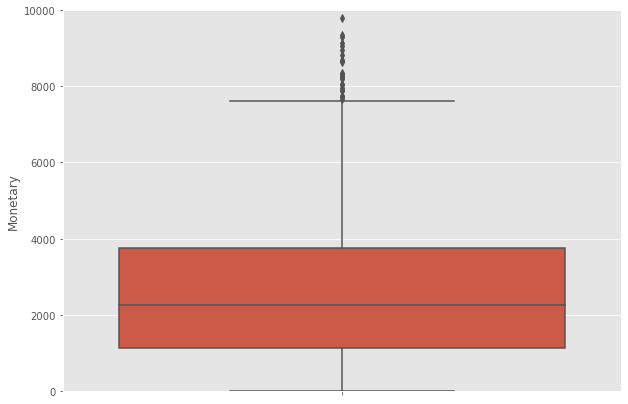

In [349]:
sns.boxplot( y = RFM['Monetary'])
plt.ylim(0,10000)

Minimum spend is $4. 

Maximum spend is about $7500. 

There are outliers i.e figures appearing above the maximum  

50% spent above and below $2k   

75% spent about $3800

## Clustering with KMeans

Here, we classify customers into groups based on recency, frequency and monetary value. A good way to find the optimal number of clusters is to use the elbow method

In [350]:
# Import more libraries for this task 
from scipy.spatial.distance import cdist
import numpy as np

# Apply the elbow method to determine number of clusters

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

Cluster inertia at 1 = 27537474.126103405
Cluster inertia at 2 = 7580350.110946748
Cluster inertia at 3 = 3875632.600902253
Cluster inertia at 4 = 2091992.2249115133
Cluster inertia at 5 = 1484357.8012261204
Cluster inertia at 6 = 994750.530102514
Cluster inertia at 7 = 655662.9598637299
Cluster inertia at 8 = 480195.4757718912
Cluster inertia at 9 = 385805.5407719822
Cluster inertia at 10 = 315271.9374109437


Text(0, 0.5, 'Inertia')

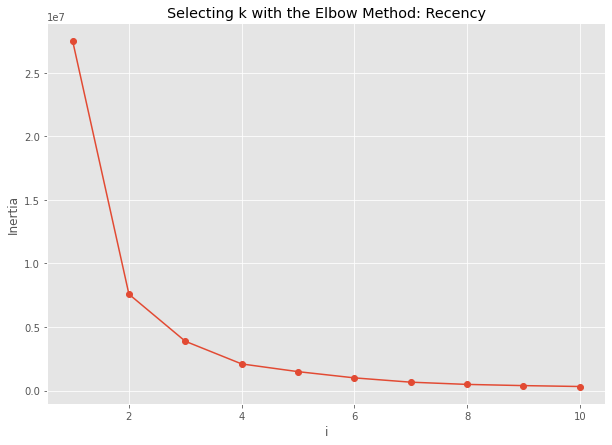

In [351]:
#recency
cs = []
for i in range(1,11):
    kmeans = KMeans(i)
    kmeans.fit(RFM[['Recency']])
    cs_iter= kmeans.inertia_ #inertia measures how spread out the clusters are from their centroids, Lower inertia is better
    cs.append(cs_iter)
    print('Cluster inertia at {} = {}'.format(i, cs_iter))
n_clust = range(1,11)    
plt.plot(n_clust, cs, marker = 'o')
plt.title('Selecting k with the Elbow Method: Recency')
plt.xlabel('i')
plt.ylabel('Inertia')

Cluster inertia at 1 = 30859.982345523313
Cluster inertia at 2 = 11143.71153231895
Cluster inertia at 3 = 5630.739841648668
Cluster inertia at 4 = 3470.8874243112873
Cluster inertia at 5 = 2153.559113800169
Cluster inertia at 6 = 1548.918959402546
Cluster inertia at 7 = 1105.1525669917555
Cluster inertia at 8 = 888.8666723141752
Cluster inertia at 9 = 674.7830444145937
Cluster inertia at 10 = 557.9382305639787


Text(0, 0.5, 'Inertia')

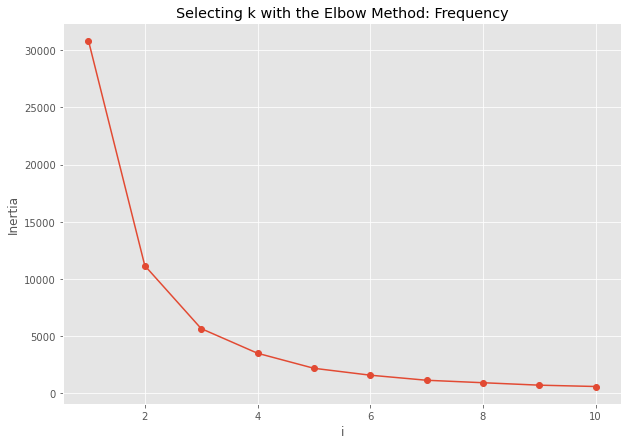

In [352]:
#frequency
cs = []
for i in range(1,11):
    kmeans = KMeans(i)
    kmeans.fit(RFM[['Frequency']])
    cs_iter= kmeans.inertia_ #inertia measures how spread out the clusters are from their centroids, Lower inertia is better
    cs.append(cs_iter)
    print('Cluster inertia at {} = {}'.format(i, cs_iter))
n_clust = range(1,11)    
plt.plot(n_clust, cs, marker = 'o')
plt.title('Selecting k with the Elbow Method: Frequency')
plt.xlabel('i')
plt.ylabel('Inertia')

Cluster inertia at 1 = 5466319340.781061
Cluster inertia at 2 = 2166475891.536741
Cluster inertia at 3 = 1180802021.6907554
Cluster inertia at 4 = 687909199.7800552
Cluster inertia at 5 = 476730756.7851751
Cluster inertia at 6 = 314990732.2932007
Cluster inertia at 7 = 233639087.274387
Cluster inertia at 8 = 177468036.92952225
Cluster inertia at 9 = 141748627.91188744
Cluster inertia at 10 = 110532589.87298317


Text(0, 0.5, 'Inertia')

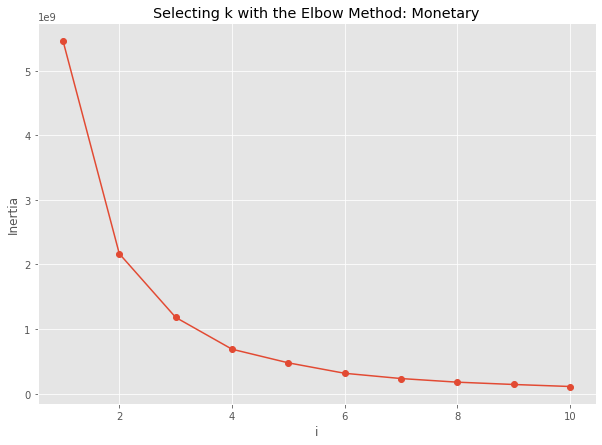

In [353]:
#frequency
cs = []
for i in range(1,11):
    kmeans = KMeans(i)
    kmeans.fit(RFM[['Monetary']])
    cs_iter= kmeans.inertia_ #inertia measures how spread out the clusters are from their centroids, Lower inertia is better
    cs.append(cs_iter)
    print('Cluster inertia at {} = {}'.format(i, cs_iter))
n_clust = range(1,11)    
plt.plot(n_clust, cs, marker = 'o')
plt.title('Selecting k with the Elbow Method: Monetary')
plt.xlabel('i')
plt.ylabel('Inertia')

From the elbow plots, we can set the kmeans hyperparameter 'k' to 5

In [354]:
# Set up kmeans to create 5 clusters
kmeans = KMeans(n_clusters = 5, random_state = 1)

In [355]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    '''
    This function is used to create a consistent order for the cluster numbers 
    that will be the output of the KMeans prediction.
    
    Parameters:
    cluster_field_name: str, name to be assigned to the cluster we are predicting for
    target_field_name: str, name of the column we're clustering 
    df: DataFrame, source of the data where prediction is to be done
    ascending: bool, order of cluster numbers
    '''
    #create column names using a prefix
    new_cluster_field_name = 'new_' + cluster_field_name
    #get mean value for the target column name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    #sort mean values in ascending order
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    #create an index
    df_new['index'] = df_new.index
    #merge the new dataframe with old dataframe
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    #remove the old column
    df_final = df_final.drop([cluster_field_name],axis=1)
    #rename the index as the metric score we want
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [356]:
# Fit the kmeans model to the Recency feature and predict clusters

# Step 1: fit the model
kmeans.fit(RFM[['Recency']])

# Step 2; predict the clusters
recency_labels = kmeans.predict(RFM[['Recency']])

In [357]:
#view the unique cluster labels
#by using a set, we ignore the repeatitions and return only unique values. Notice that the labels correspond to the
#number of clusters set in the n_clusters parameter when initializing KMeans
set(recency_labels)

{0, 1, 2, 3, 4}

In [358]:
#add clusters to our RFM dataframe
RFM['Recency_Score'] = recency_labels

In [359]:
# Reorder the clusters so that they are sequential
RFM = order_cluster('Recency_Score', 'Recency',RFM,True)


In [360]:
#view summary statistics
RFM.groupby('Recency_Score').Recency.describe().T

Recency_Score,0,1,2,3,4
count,29.000000,80.000000,98.000000,204.000000,382.000000
mean,-806.896552,-447.775000,-236.500000,-110.357843,-31.128272
std,143.366500,72.554297,46.607209,26.916298,18.821214
min,-1164.000000,-614.000000,-338.000000,-172.000000,-70.000000
25%,-834.000000,-497.250000,-277.750000,-125.000000,-46.000000
50%,-768.000000,-421.000000,-226.000000,-106.000000,-29.000000
75%,-718.000000,-391.000000,-196.250000,-89.750000,-16.000000
max,-637.000000,-344.000000,-174.000000,-71.000000,0.000000


In Cluster 5 (labelled '4' above),  285 out of 380 customers ordered something as recent as 16 days ago.  

About 190 of the customers ordered something 29 days ago - within the context of this data.  

Cluster 4 should raise red flags unless the goods in question are one off items. Exploratory data analysis will answer this question. 



<AxesSubplot:xlabel='Customer ID', ylabel='Recency'>

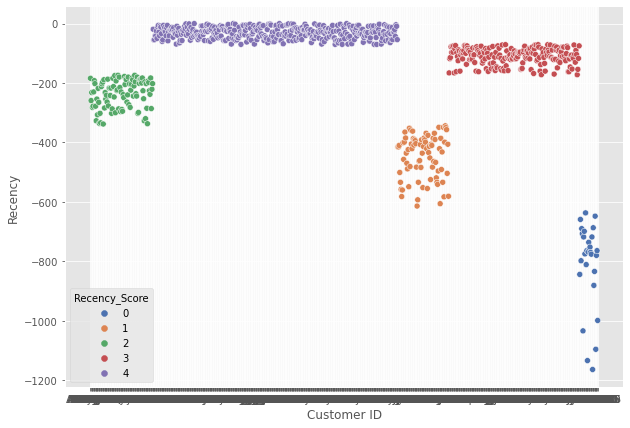

In [361]:
# Add a little bit of color
sns.scatterplot(x = RFM['Customer ID'], y = 'Recency', hue = 'Recency_Score', data = RFM, palette= 'deep')

# Frequency Clusters

In [362]:
# fit the model
kmeans.fit(RFM[['Frequency']])

#predict clusters
frequency_labels = kmeans.predict(RFM[['Frequency']]) 

#save clusters to dataframe
RFM['Frequency_Score'] = frequency_labels

# reorder the clusters
RFM = order_cluster('Frequency_Score', 'Frequency', RFM, True)



In [363]:
RFM.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score
0,AA-10315,-184,11,5563.5600,2,1
1,AA-10480,-259,12,1790.5120,2,1
2,AH-10465,-230,8,2495.3916,2,1
3,BD-11770,-327,10,658.4660,2,1
4,BS-11800,-265,8,949.4300,2,1


In [364]:
# View Frequency summary statistics 
RFM.groupby('Frequency_Score')['Frequency'].describe().T

Frequency_Score,0,1,2,3,4
count,172.000000,259.000000,203.000000,114.000000,45.000000
mean,5.168605,9.992278,14.650246,20.035088,27.733333
std,1.710153,1.338147,1.353703,1.568099,3.466725
min,1.000000,8.000000,13.000000,18.000000,24.000000
25%,4.000000,9.000000,14.000000,19.000000,25.000000
50%,6.000000,10.000000,14.000000,20.000000,27.000000
75%,7.000000,11.000000,16.000000,21.000000,30.000000
max,7.000000,12.000000,17.000000,23.000000,37.000000


<AxesSubplot:xlabel='Customer ID', ylabel='Frequency'>

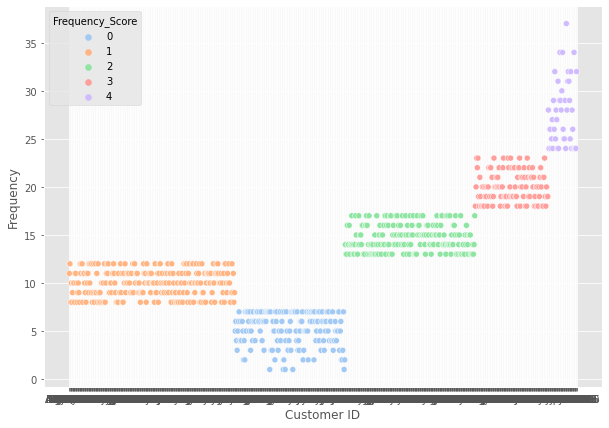

In [365]:
sns.scatterplot(x = RFM['Customer ID'], y = 'Frequency', hue = 'Frequency_Score', data = RFM, palette = 'pastel')

# Monetary value clusters

In [366]:
#fit the model
kmeans.fit(RFM[['Monetary']])

#predict clusters 
monetary_labels = kmeans.predict(RFM[['Monetary']])

# save clusters in data frame
RFM['Monetary_Score'] = monetary_labels

#order the clusters
RFM = order_cluster('Monetary_Score', 'Monetary', RFM, True)

# View descriptive information on the clusters

RFM.groupby('Monetary_Score')['Monetary'].describe().T

Monetary_Score,0,1,2,3,4
count,346.000000,275.000000,118.000000,46.000000,8.000000
mean,1004.349838,2844.044321,5223.936874,8972.979304,16184.082375
std,519.539521,565.020635,806.322088,1546.362462,4008.206477
min,4.833000,1934.272000,4046.746000,7198.761000,12873.298000
25%,619.261000,2357.765500,4503.742500,7755.137000,14167.005250
50%,1020.622500,2797.668000,5087.427500,8336.847000,14534.595500
75%,1421.399750,3252.643000,5903.047750,10183.140750,16101.058750
max,1911.844000,3990.689000,6987.196000,12209.438000,25043.050000


Cluster 4 has 8 customers where 75% of them spend at least $14k individually.  

Minimum spend for this cluster is $11k

<AxesSubplot:xlabel='Customer ID', ylabel='Monetary'>

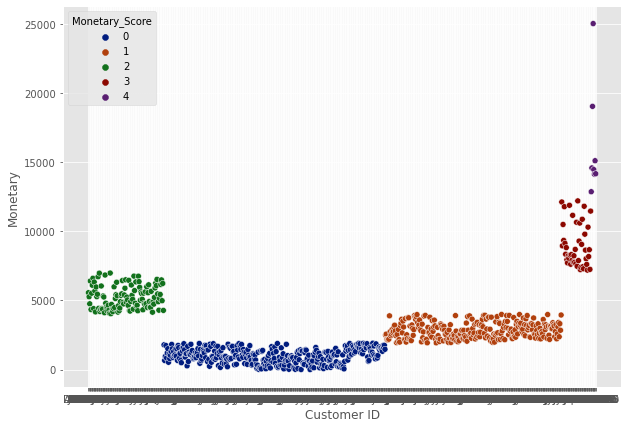

In [367]:
sns.scatterplot(x = RFM['Customer ID'], y = 'Monetary', hue = 'Monetary_Score', data = RFM, palette = 'dark')

### What is the overall RFM score for each customer?

In [368]:
# Create a column in RFM that has a sum of the scores
RFM['Overall_Score'] = RFM[['Monetary_Score', 'Recency_Score', 'Frequency_Score']].sum(axis = 1)
RFM.head(3)

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score
0,AA-10315,-184,11,5563.560,2,1,2,5
1,DW-13480,-217,11,5271.628,2,1,2,5
2,JK-15640,-180,12,4760.434,2,1,2,5


In [369]:
# What is the maximum score a customer has?
RFM.Overall_Score.max()

# why is the score 12? There are 3 features to assess the customers- recency, frequency and monetary value. the maximum any customer can have based on the clusters created (remember 0 indexing?) is 4.


12

In [370]:
RFM.describe()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,-147.292560,12.588903,2885.588260,3.046658,1.496847,0.858764,5.402270
std,186.465917,6.242165,2627.150235,1.156489,1.146053,0.942931,2.424276
min,-1164.000000,1.000000,4.833000,0.000000,0.000000,0.000000,0.000000
25%,-183.000000,8.000000,1137.616000,2.000000,1.000000,0.000000,4.000000
50%,-76.000000,12.000000,2243.510000,3.000000,1.000000,1.000000,5.000000
75%,-30.000000,16.000000,3747.668000,4.000000,2.000000,1.000000,7.000000
max,0.000000,37.000000,25043.050000,4.000000,4.000000,4.000000,12.000000


Looking at the overall score, half of the customers score less than 6 points  

75% of the customers have a score of 7  



In [371]:
#Check distribution of scores from 0 to 12

RFM.Overall_Score.sort_values().value_counts().sort_index()

0      15
1      38
2      44
3      73
4     114
5     133
6     105
7     108
8      75
9      56
10     25
11      6
12      1
Name: Overall_Score, dtype: int64

Text(0.5, 0, 'Overall Score')

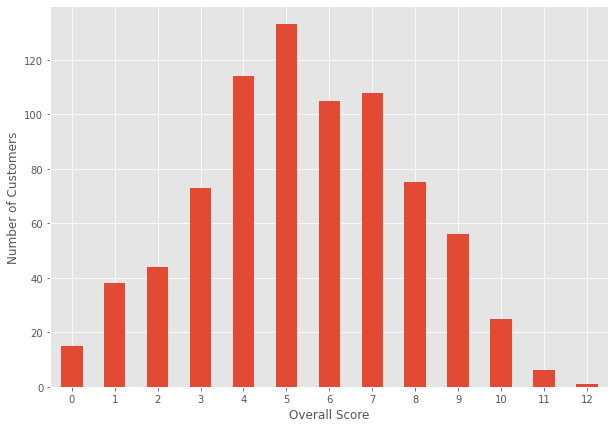

In [372]:
# You can eyeball the results above but pictures help process information easily. Here, a bar plot is used to tell the same story


RFM.Overall_Score.sort_values().value_counts().sort_index().plot.bar()
plt.xticks(rotation = 0)
plt.ylabel('Number of Customers')
plt.xlabel('Overall Score')


In [373]:
# Draw up descriptive stats for the overall score by monetary value

RFM.groupby('Overall_Score')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
Overall_Score,,,,,,,,
0,15.0,539.948533,464.280988,48.360,228.80700,368.8800,812.00400,1537.2360
1,38.0,943.356895,653.088082,4.833,448.53900,885.3980,1357.62650,2390.5340
2,44.0,1042.958607,825.224531,16.739,396.39100,931.4195,1355.21300,3246.6260
3,73.0,1292.224181,910.684487,71.263,742.08200,1090.8380,1613.40200,3984.4524
4,114.0,1424.038818,1052.160267,22.328,698.65500,1266.7970,1883.42500,6979.1800
5,133.0,1934.783350,1406.146192,239.481,1008.13600,1582.1090,2461.40400,10501.6530
6,105.0,3095.904996,2066.510416,1056.390,2005.59600,2876.0460,3589.29600,19052.2180
7,108.0,3678.628027,1770.986311,1324.028,2485.02175,3207.8860,4307.50825,11789.6300
8,75.0,4496.489172,2230.137154,2218.980,3012.61050,4159.7700,4880.12150,14142.3340


Text(0.5, 1.0, 'Frequency vs Overall Score')

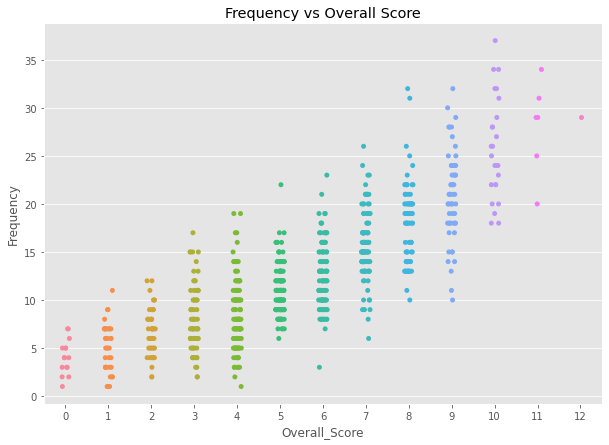

In [374]:
# Plot overall score by purchase frequency
sns.stripplot(y='Frequency',x='Overall_Score',data = RFM)
plt.title('Frequency vs Overall Score')

Text(0.5, 1.0, 'Recency vs Overall Score')

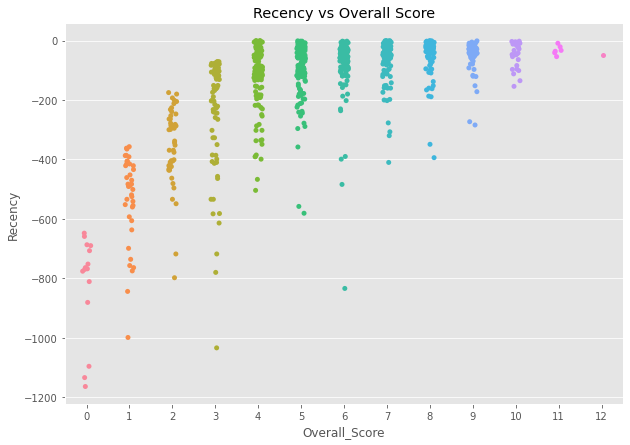

In [375]:
# Plot overall score by purchase recency
sns.stripplot(y='Recency',x='Overall_Score',data = RFM)
plt.title('Recency vs Overall Score')

Text(0.5, 1.0, 'Monetary Value vs Overall Score')

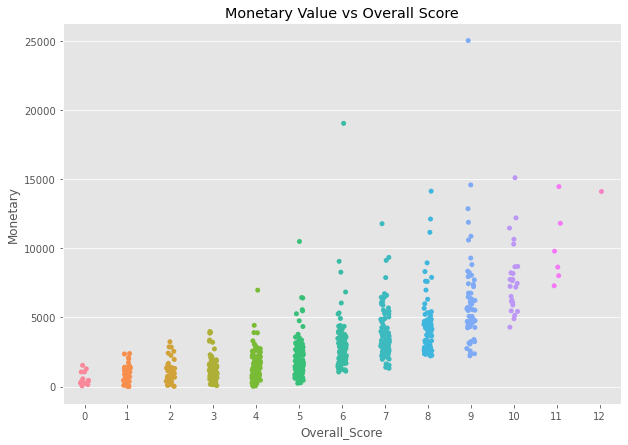

In [376]:
# Plot overall score by monetary value
sns.stripplot(y='Monetary',x='Overall_Score',data = RFM)
plt.title('Monetary Value vs Overall Score')

Given the scores, it is possible to create segments that streamline the type of customers that exist. 

In [377]:
RFM['Segment'] = 'Low Value'
RFM.loc[RFM.Overall_Score >5, 'Segment'] = 'Mid Value'
RFM.loc[RFM.Overall_Score >8, 'Segment'] = 'HighValue'

In [378]:
RFM.Segment.value_counts()

Low Value    417
Mid Value    288
HighValue     88
Name: Segment, dtype: int64

In [379]:
#Which customer has the perfect score of 12?

RFM[RFM['Overall_Score']== 12]

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
792,KL-16645,-47,29,14175.229,4,4,4,12,HighValue


In [380]:
# What is the maximum spend>
RFM.Monetary.max()

25043.05

In [381]:
# Which customer spent the maximum and why is their score not a 12?

RFM[RFM.Monetary >25000]

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
788,SM-20320,-79,15,25043.05,3,2,4,9,HighValue


The customer is still high value but the frequency scores is rather low. 

In [382]:
RFM.Segment.value_counts(normalize = True)

Low Value    0.525851
Mid Value    0.363178
HighValue    0.110971
Name: Segment, dtype: float64

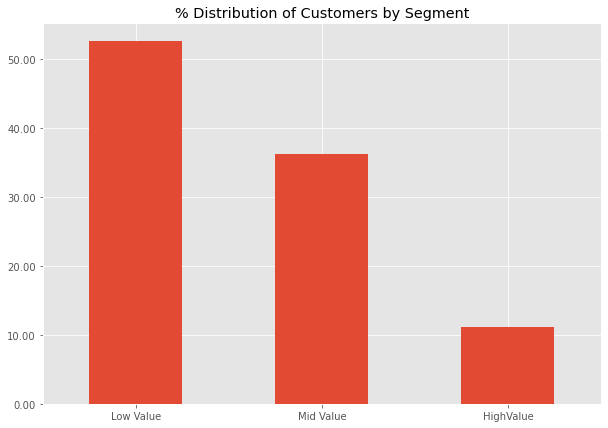

In [384]:
from matplotlib.ticker import StrMethodFormatter
A = RFM.Segment.value_counts(normalize = True) *100
A.plot.bar()
plt.title('% Distribution of Customers by Segment')
plt.xticks(rotation = 0)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

In [385]:
2022-1989

33